In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# Define path to the data directory
data_dir = Path('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
train_dir

PosixPath('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

In [4]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'Normal'
Cyst_cases_dir = train_dir / 'Cyst'
Stone_cases_dir = train_dir / 'Stone'
Tumor_cases_dir = train_dir / 'Tumor'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpg')
Cyst_cases = Cyst_cases_dir.glob('*.jpg')
Stone_cases = Stone_cases_dir.glob('*.jpg')
Tumor_cases = Tumor_cases_dir.glob('*.jpg')


# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []


# Go through all the Cyst_cases . The label for these cases will be 1
for img in Cyst_cases:
    train_data.append((img, 0))
    # Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,1))

# Go through all the normal cases. The label for these cases will be 0
for img in Stone_cases:
    train_data.append((img,2))

# Go through all the Tumor_cases . The label for these cases will be 1
for img in Tumor_cases:
    train_data.append((img, 3))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,../input/ct-kidney-dataset-normal-cyst-tumor-a...,1
1,../input/ct-kidney-dataset-normal-cyst-tumor-a...,3
2,../input/ct-kidney-dataset-normal-cyst-tumor-a...,1
3,../input/ct-kidney-dataset-normal-cyst-tumor-a...,0
4,../input/ct-kidney-dataset-normal-cyst-tumor-a...,0


In [5]:
train_data['label'].unique()

array([1, 3, 0, 2])

label
1    5077
0    3709
3    2283
2    1377
Name: count, dtype: int64


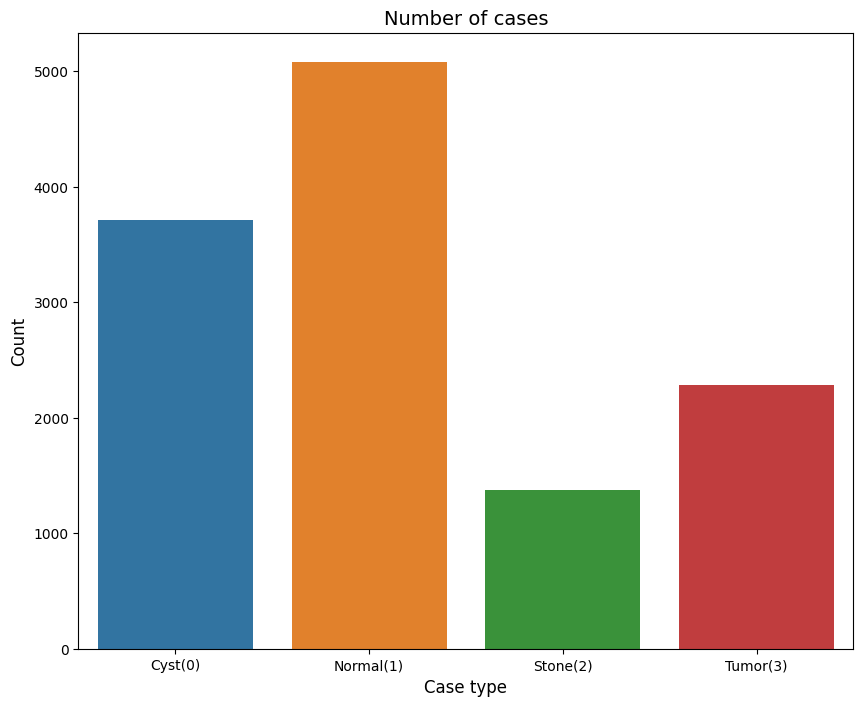

In [6]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Cyst(0)','Normal(1)', 'Stone(2)', 'Tumor(3)'])
plt.show()

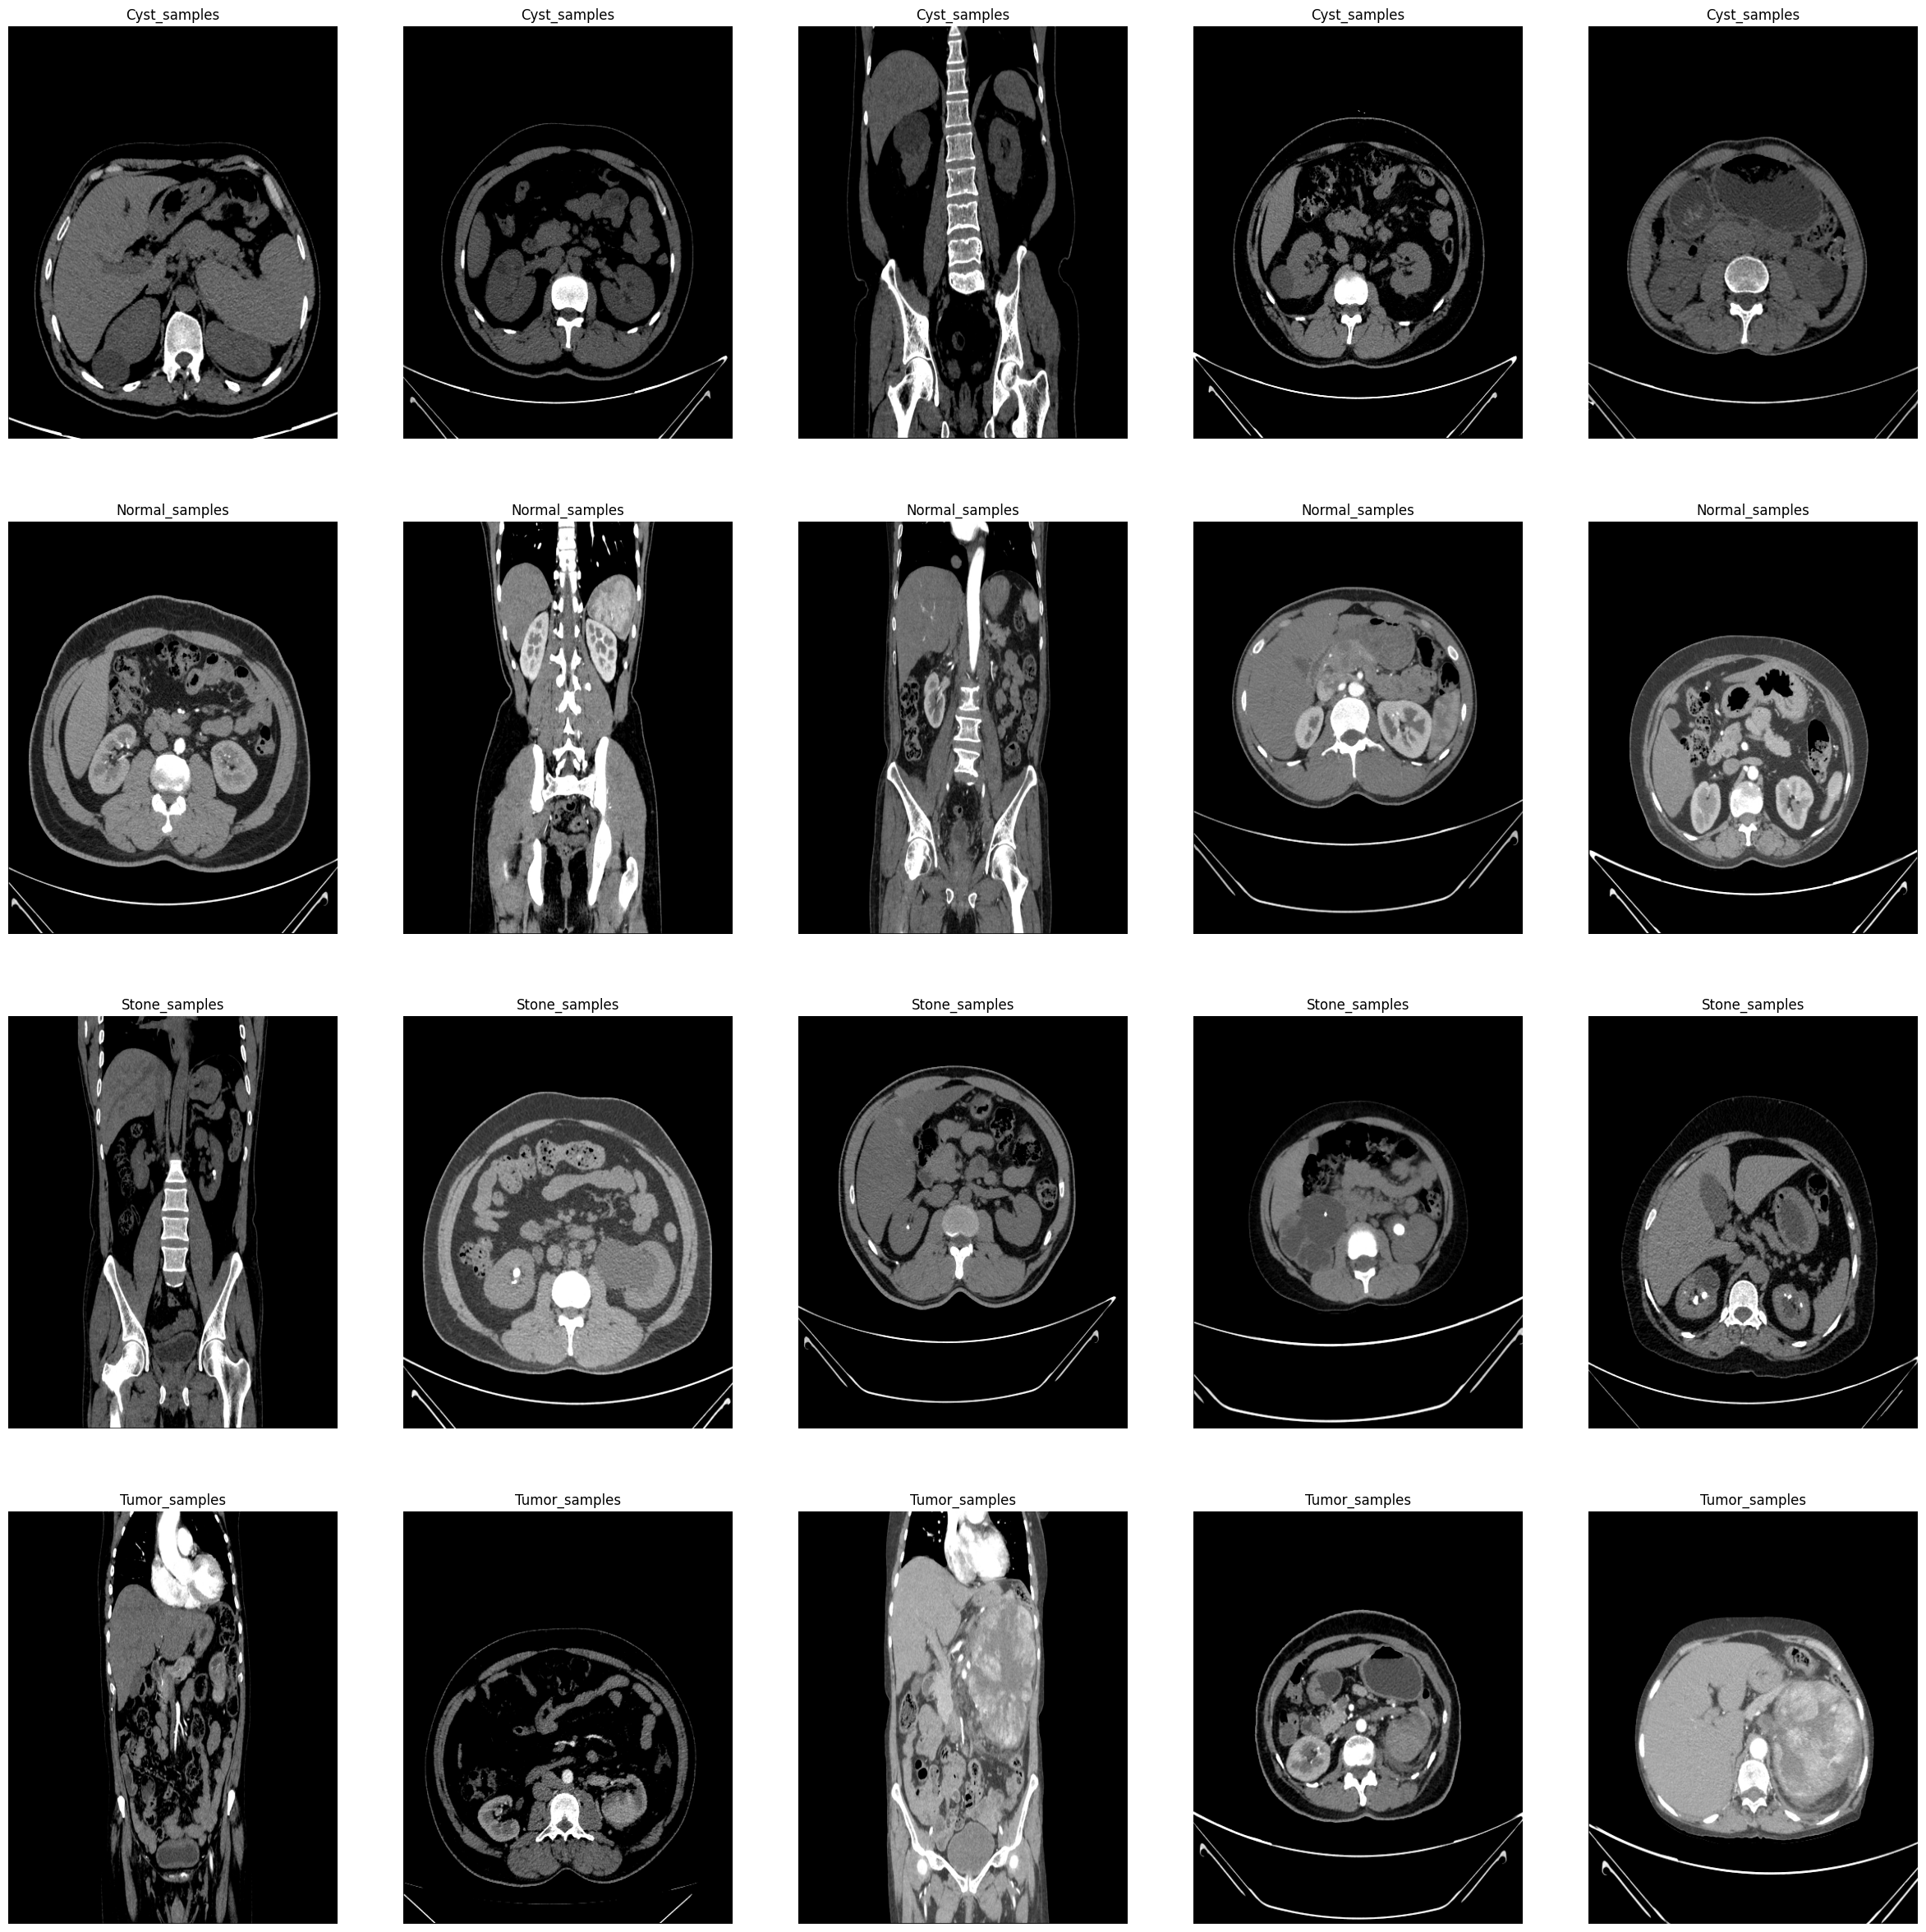

In [7]:
# Get few samples for both the classes
Cyst_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
Normal_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
Stone_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
Tumor_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Cyst_samples + Normal_samples+Stone_samples+Tumor_samples
del Cyst_samples, Normal_samples,Stone_samples,Tumor_samples

# Plot the data 
f, ax = plt.subplots(4,5, figsize=(30,30))
for i in range(20):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Cyst_samples")
    elif i<10:
        ax[i//5, i%5].set_title("Normal_samples")
    elif i<15:
        ax[i//5, i%5].set_title("Stone_samples")
    elif i<20:
        ax[i//5, i%5].set_title("Tumor_samples")
    
        
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [8]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'Normal'
Cyst_cases_dir = train_dir / 'Cyst'
Stone_cases_dir = train_dir / 'Stone'
Tumor_cases_dir = train_dir / 'Tumor'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpg')
Cyst_cases = Cyst_cases_dir.glob('*.jpg')
Stone_cases = Stone_cases_dir.glob('*.jpg')
Tumor_cases = Tumor_cases_dir.glob('*.jpg')
train_data = []
train_labels = []
#from keras.utils.np_utils import to_categorical
length, width = 128,128
for img in Cyst_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (length, width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Cyst'
    train_data.append(img)
    train_labels.append(label)

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (length, width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label ='Normal'
    train_data.append(img)
    train_labels.append(label)
                      
for img in Stone_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (length, width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Stone'
    train_data.append(img)
    train_labels.append(label)
    
for img in Tumor_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (length, width))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Tumor'
    train_data.append(img)
    train_labels.append(label)
# Convert the list into numpy arrays

train_data = np.array(train_data)
train_labels = np.array(train_labels)


In [9]:
print("Total number of validation examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of validation examples:  (12446, 128, 128, 3)
Total number of labels: (12446,)


In [10]:
train_data=np.moveaxis(train_data, -1, 1)
# train_labels= np.moveaxis(train_labels, -1, 1)

print("Total number of validation examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of validation examples:  (12446, 3, 128, 128)
Total number of labels: (12446,)


In [11]:
train_data.shape

(12446, 3, 128, 128)

In [12]:
train_labels

array(['Cyst', 'Cyst', 'Cyst', ..., 'Tumor', 'Tumor', 'Tumor'],
      dtype='<U6')

In [13]:
# Assuming train_labels is your string array
label_mapping = {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

# Use a list comprehension to map the labels
train_labels = [label_mapping[label] for label in train_labels]
train_labels=np.asarray(train_labels)

In [14]:
import torch

# Assuming y_train is your NumPy array
train_labels = torch.from_numpy(train_labels).long()


In [15]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size = 0.18,
                                                                            shuffle = True, random_state = 42)

In [16]:
import numpy as np 
import pandas as pd
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [17]:
BATCH = 32
EPOCHS = 2
LR = 0.001

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
Transform = transforms.Compose(
    [transforms.ToTensor()])
class GetData(Dataset):
    def __init__(self, X_Train, Y_Train, Transform):
        self.X = X_Train.astype('float32')
        self.transform = Transform
        self.Y = Y_Train
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.transform(self.X[index]).permute((1, 2, 0)).contiguous(), self.Y[index]
trainset = GetData(X_train, y_train, Transform)
valset = GetData(X_test, y_test, Transform)
train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=4)
test_loader = DataLoader(valset, batch_size=BATCH, num_workers=4)
next(iter(train_loader))[0].shape

torch.Size([32, 3, 128, 128])

In [ ]:
wt

# transformer based model

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
# Modify the final classification layer to match your task
model.head = nn.Linear(model.head.in_features, 4, bias=True)  # Assuming you have 4 classes

#model.to(DEVICE)

In [ ]:
# Initialize a pretrained Vision Transformer model
model = torchvision.models.video.r3d_18(pretrained=True)  # Change the model class and name as per your requirement

# Modify the final classification layer to match your task
model.fc = nn.Linear(model.fc.in_features, 4, bias=True)  # Assuming you have 4 classes

# Move the model to the selected device
model.to(DEVICE)

In [ ]:
# Define the number of classes in your classification task
num_classes = 4  # Replace with the actual number of classes in your task

# Initialize the ViT model with pre-trained weights
model = torchvision.models.vit.base(pretrained=True)

# Replace the final fully connected layer to match the number of classes in your task
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(DEVICE)

In [ ]:
pip install vit-pytorch

In [ ]:
import torch
from vit_pytorch import ViT
model = ViT(
            image_size = 128,
            patch_size = 16,
            num_classes = 4,
            dim = 1024,
            depth = 16,
            heads = 16,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1
        )
model.to(DEVICE)

In [ ]:
import torch
from swin_transformer_pytorch import SwinTransformer

# Define the Swin Transformer model
model = SwinTransformer(
    image_size=128,
    patch_size=4,
    in_chans=3,  # Number of input channels (e.g., 3 for RGB images)
    num_classes=4,  # Number of output classes
    embed_dim=96,
    depths=[2, 2, 6, 2],  # Number of layers for each stage
    num_heads=[3, 6, 12, 24],  # Number of heads for each stage
    window_size=7,
    mlp_ratio=4.0,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    drop_path_rate=0.1,
    ape=False,
    patch_norm=True,
    use_checkpoint=False,
)

model.to(DEVICE)  # Replace DEVICE with your desired device (e.g., 'cuda' or 'cpu')


# CNN Based

In [19]:
model = torchvision.models.resnet152()
model.fc = nn.Linear(2048, 4, bias=True)
model.to(DEVICE)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torchvision.models as models

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the fully connected layer for your classification task
model.fc = nn.Linear(2048, 4, bias=True)

# Move the model to your chosen device (e.g., GPU if available)
#model.to(DEVICE)


In [ ]:
import torchvision.models as models

# Load the pre-trained VGG-16 model
model = models.vgg16(pretrained=True)

# Modify the fully connected layer for your classification task
model.classifier[6] = nn.Linear(4096, 4, bias=True)

# Move the model to your chosen device (e.g., GPU if available)
#model.to(DEVICE)


In [ ]:
import torchvision.models as models

# Load the pre-trained AlexNet model
model3 = models.alexnet(pretrained=True)

# Modify the fully connected layer for your classification task
model3.classifier[6] = nn.Linear(4096, 4)  # Modify the last fully connected layer

# Move the model to your chosen device (e.g., GPU if available)
#model3.to(DEVICE)


In [ ]:
# Model initialization
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = torchvision.models.inception_v3(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)

model.to(DEVICE)

In [20]:
device=DEVICE

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
#model=model1

In [23]:
from tqdm import tqdm
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

EPOCHS = 5

for epoch in range(EPOCHS):
    tr_loss = 0.0
    correct_train = 0
    total_train = 0

    model = model.train()
    
    # Training loop
    for i, (images, labels) in enumerate(tqdm(train_loader, leave=False)):
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        tr_loss += loss.item()

        _, predicted = torch.max(logits.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(tr_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    model = model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(test_loader, leave=False)):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(images)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{EPOCHS} | '
          f'Training Loss: {tr_loss:.4f} | Training Accuracy: {train_accuracy:.2f}% | '
          f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')

print('Training completed.')

Epoch 1/5 | Training Loss: 199.1873 | Training Accuracy: 77.76% | Validation Loss: 28.4653 | Validation Accuracy: 85.10%


Epoch 2/5 | Training Loss: 53.5290 | Training Accuracy: 94.39% | Validation Loss: 4.7901 | Validation Accuracy: 97.90%


Epoch 3/5 | Training Loss: 27.6206 | Training Accuracy: 97.10% | Validation Loss: 10.2826 | Validation Accuracy: 95.27%


Epoch 4/5 | Training Loss: 18.0890 | Training Accuracy: 98.19% | Validation Loss: 3.2348 | Validation Accuracy: 98.48%


Epoch 5/5 | Training Loss: 15.6941 | Training Accuracy: 98.37% | Validation Loss: 1.5585 | Validation Accuracy: 99.29%
Training completed.


In [24]:
from sklearn.metrics import classification_report

# Ensure that your model is in evaluation mode
model = model.eval()

# Create lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Inference loop
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)
        _, predicted = torch.max(logits, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Generate a classification report
classification_report_result = classification_report(all_true_labels, all_predictions)

# Print the classification report
print(classification_report_result)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       687
           1       0.99      1.00      0.99       908
           2       0.98      1.00      0.99       254
           3       0.99      0.98      0.99       392

    accuracy                           0.99      2241
   macro avg       0.99      0.99      0.99      2241
weighted avg       0.99      0.99      0.99      2241



In [25]:
from sklearn.metrics import classification_report

print(classification_report(all_true_labels, all_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       687
           1       0.99      1.00      0.99       908
           2       0.98      1.00      0.99       254
           3       0.99      0.98      0.99       392

    accuracy                           0.99      2241
   macro avg       0.99      0.99      0.99      2241
weighted avg       0.99      0.99      0.99      2241



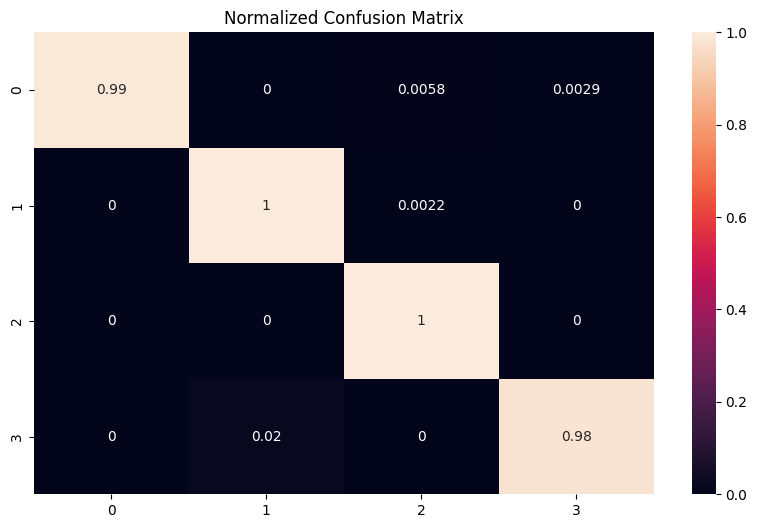

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(all_true_labels, all_predictions, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(all_true_labels)), yticklabels = sorted(set(all_true_labels)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [27]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
        
final_layer = model._modules.get('layer4')
#final_layer = model.layer4[-1]

activated_features = SaveFeatures(final_layer)

In [28]:
for batch_i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        break

In [29]:
## Probabilities & labels for each images
output = model(data[:8])# conver to cuda for softmax
probabilities = F.softmax(output,dim=1).data.squeeze()
pred_idx = np.argmax(probabilities.cpu().detach().numpy(),axis=1)
labels = pred_idx
#activated_features.remove()
print('Probabilities classes: %s \n Prediction indices %s \n Labels: %s' % (probabilities, pred_idx, labels))

Probabilities classes: tensor([[1.1914e-06, 4.0188e-06, 1.5178e-09, 9.9999e-01],
        [9.9617e-01, 5.5917e-05, 3.7599e-03, 1.5783e-05],
        [1.0811e-05, 2.6907e-05, 2.6067e-08, 9.9996e-01],
        [9.9825e-01, 1.7095e-04, 1.5831e-03, 6.2866e-07],
        [9.9987e-01, 4.7068e-08, 9.0626e-05, 3.8923e-05],
        [7.9633e-10, 9.9999e-01, 1.1348e-08, 1.4560e-05],
        [9.9851e-01, 2.0801e-04, 1.2861e-03, 3.8253e-07],
        [7.5482e-05, 6.8201e-04, 9.9924e-01, 3.0739e-06]], device='cuda:0') 
 Prediction indices [3 0 3 0 0 1 0 2] 
 Labels: [3 0 3 0 0 1 0 2]


In [30]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv[0,:, :, ].reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
weight_softmax_params

[Parameter containing:
 tensor([[ 0.0244,  0.0102,  0.0282,  ..., -0.0393, -0.0061, -0.0246],
         [-0.0086, -0.0263, -0.0189,  ...,  0.0273, -0.0079,  0.0285],
         [-0.0086,  0.0047, -0.0116,  ..., -0.0384, -0.0230,  0.0274],
         [-0.0158,  0.0155, -0.0348,  ...,  0.0174, -0.0080, -0.0178]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0145, -0.0088, -0.0021, -0.0207], device='cuda:0',
        requires_grad=True)]

In [31]:
## Current images & their heatmaps
cur_images = data.cpu().numpy().transpose((0, 2, 3, 1))
heatmaps = []
for i in pred_idx:
    img = getCAM(activated_features.features, weight_softmax, i)
    heatmaps.append(img)
    
print(cur_images.shape, len(heatmaps))

(32, 128, 128, 3) 8


In [32]:
# Probability for each images
proba = []
for i in probabilities.cpu().detach().numpy():
    idx = np.argmax(i)
    proba.append((str(np.round(i[idx]*100,2)))+'%')
print(proba)

['100.0%', '99.62%', '100.0%', '99.82%', '99.99%', '100.0%', '99.85%', '99.92%']


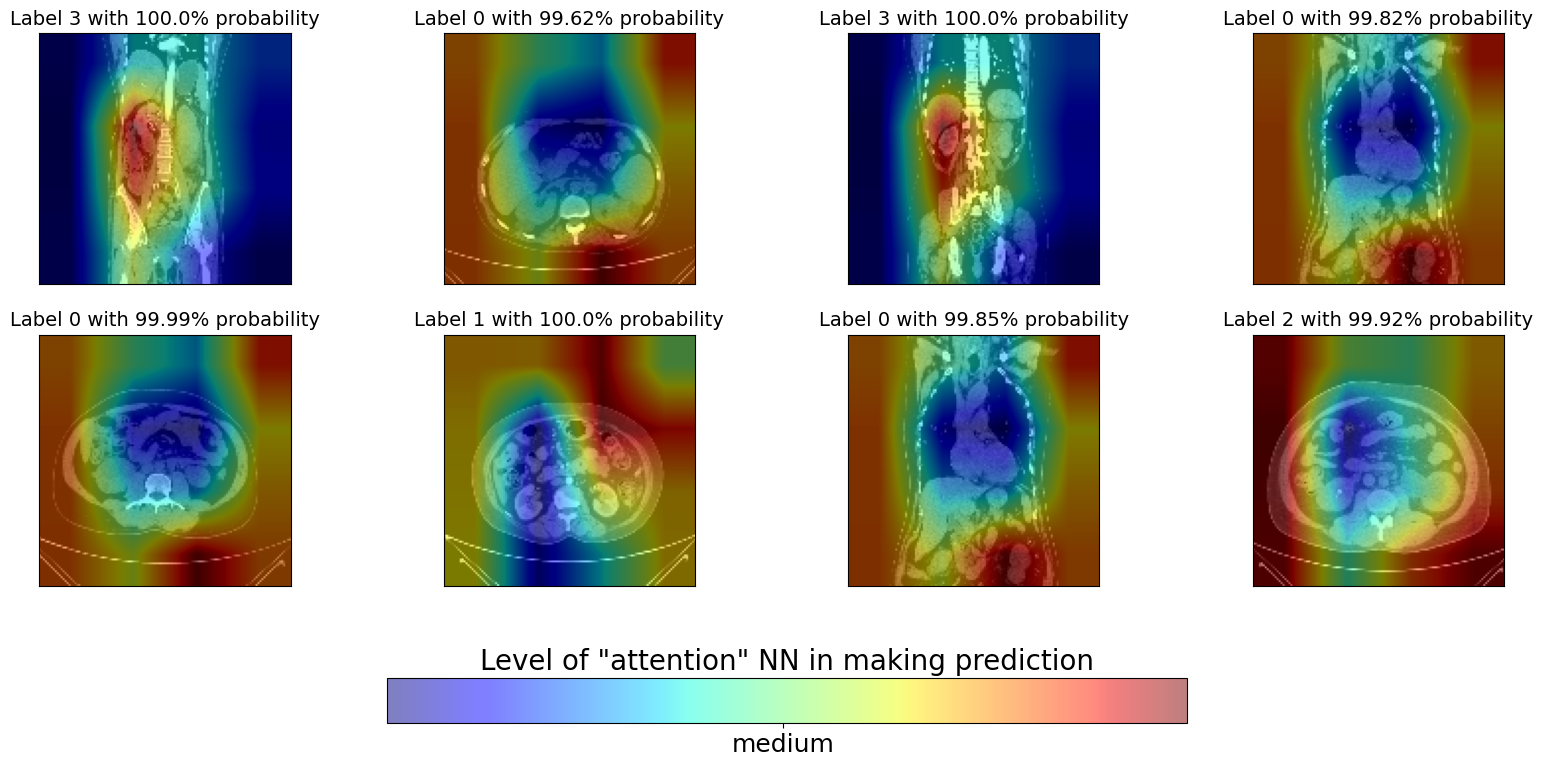

In [33]:
fig=plt.figure(figsize=(20,15))
for i in range(0, len(cur_images[:8])):
    img = cur_images[i]
    mask = heatmaps[i]
    ax = fig.add_subplot(4, 4,i +1,xticks=[], yticks=[])
    plt.imshow(img)
    plt.imshow(cv2.resize(mask, (length, width), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet');
    ax.set_title('Label %d with %s probability' % (labels[i], proba[i]),fontsize=14)
    
#cax = fig.add_axes([0.3, 0.42, 0.4, 0.04]) # place where be map
cax = fig.add_axes([0.32, 0.42, 0.4, 0.03]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=20)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=18)


plt.show()

In [34]:
wt

NameError: name 'wt' is not defined

In [ ]:
pip install patchify

In [ ]:
import numpy as np
from patchify import patchify

image = np.random.rand(448, 448, 128)
patch_size = (64, 64, 16)

# Set the stride to be the same as the patch size
stride = patch_size

patches = patchify(image, patch_size, step=stride)
print(patches.shape)
